# Process Weather Station Data - Camera to Weather Station Mapping

<b>Summary:</b><br>
Uses the data from the Synoptic Weather Data API to grab weather station metadata and map nearest stations to hpwren cameras.<br>
Synoptic is partner of SDG&E, helping store and serve their weather station data--accessible via API.

- Read in raw weather station metadata
- Read in processed camera metadata
- Filter out weather stations to ensure they have at least 1 years worth of data for time period
- Map up to nearest x stations to each camera by looking in its defined field of view:
    1. In cameras direction (assumes 180° fov)
    2. y miles from camera
- Save camera-to-stations mapping file

<b>Output:</b><br>
.<br>
└── data<br>
&emsp;&emsp;&emsp;└── processed<br>
&emsp;&emsp;&emsp;&nbsp;&nbsp;&emsp;&emsp;&nbsp;└── camera_station_mappings.csv<br>

<b>Instructions:</b><br>
- See README.md in directory

<b>Areas for Improvement:</b><br>
- Improve weather mapping - station selection (i.e. instead of choosing closest weather stations with at least 1 year of data, choose weather stations that have the most data within time range then closest)

In [1]:
import json
from datetime import datetime

import geopandas
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
from geopandas import GeoDataFrame
from shapely.geometry import Point

## Parameters

In [2]:
#########################
# for station mapping ###
#########################
MILES = 35
CLOSEST_X = 3
#########################
#########################

# Base url and API token
with open("config.json") as config_file:
    cfg = json.load(config_file)

API_BASE_URL = cfg["synoptic_base_url"]
API_TOKEN = cfg["synoptic_api_token"]

# should be SHORTNAME values from mesonet
WEATHER_NETWORKS = cfg["weather_networks"]
WEATHER_NETWORKS = {int(k): v for k, v in WEATHER_NETWORKS.items()}  # convert id to int

# figlib start = 2016-06-04 (assume PST)
# figlib end = 2021-07-11 (assume PST)
# YYYYmmddHHMM (format needed for api)
START_DATETIME = cfg["weather_start_datetime"]
END_DATETIME = cfg["weather_end_datetime"]

## Determine nearest weather stations for each camera "field of view"

Methodology:
- Determine camera direction
- Calculate distance from every camera to every station
- Determine if each station is in the correct direction of the camera
- For each camera, calculate a row number for each station by distance (only for cameras in direction)

- Filter dataset by the following:
    - Find stations within camera view distance: 35 miles (adjustable)
    - Find stations in front of camera direction: assume 180 degree fov
    - Limit to nearest x: 3 (adjustable)

Areas for improvement:
- Adjust lens field of view from 180 degrees; in reality most camreas have 90 degree field of views with a fiew ~100 depending on camera model
- Camera distance is approximated upon analyzing a handful of different cameras and converting pixel to world coordinates; can be improved per camera if tilt angle known

### Read camera metadata

In [3]:
hpwren_cameras_metadata_df = pd.read_csv(
    "../../data/processed/camera_metadata_hpwren.csv"
)
print(hpwren_cameras_metadata_df.shape)

(138, 15)


In [4]:
hpwren_cameras_metadata_df.head()

,camera_id,direction,camera_name,image_id,prev_image_ids,long,lat,elevation,geometry.type,geometry.coordinates,x_resolution,y_resolution,center_lat,center_long,properties.description.url
0,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",NaN,NaN,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html
1,hpwren1_north,north,Big Black Mountain,bm-n-mobo-c,[''],-116.808092,33.159927,4055.0,Point,"[-116.8081, 33.1599, 4055]",3072.0,2048.0,33.181599,-116.807554,http://hpwren.ucsd.edu/cameras/BBlackMtn.html
2,hpwren1_east,east,Big Black Mountain,bm-e-mobo-c,[''],-116.808092,33.159927,4055.0,Point,"[-116.8081, 33.1599, 4055]",3072.0,2048.0,33.158781,-116.790230,http://hpwren.ucsd.edu/cameras/BBlackMtn.html
3,hpwren1_south,south,Big Black Mountain,bm-s-mobo-c,[''],-116.808092,33.159927,4055.0,Point,"[-116.8081, 33.1599, 4055]",3072.0,2048.0,33.157932,-116.807962,http://hpwren.ucsd.edu/cameras/BBlackMtn.html
4,hpwren1_west,west,Big Black Mountain,bm-w-mobo-c,[''],-116.808092,33.159927,4055.0,Point,"[-116.8081, 33.1599, 4055]",3072.0,2048.0,33.159091,-116.858706,http://hpwren.ucsd.edu/cameras/BBlackMtn.html


### Convert camera coords to geospatial point

In [5]:
# Generate spatial points for each camera lat, long
camera_geometry = [
    Point(xy)
    for xy in zip(hpwren_cameras_metadata_df.long, hpwren_cameras_metadata_df.lat)
]

# Convert df to geopandas df and append geometry column
hpwren_cameras_metadata_gdf = GeoDataFrame(
    hpwren_cameras_metadata_df, crs="EPSG:4326", geometry=camera_geometry
)  # epsg code 4326 = wgs84

In [6]:
hpwren_cameras_metadata_gdf.head()[["long", "lat", "geometry"]]

,long,lat,geometry
0,-117.120000,32.550000,POINT (-117.12000 32.55000)
1,-116.808092,33.159927,POINT (-116.80809 33.15993)
2,-116.808092,33.159927,POINT (-116.80809 33.15993)
3,-116.808092,33.159927,POINT (-116.80809 33.15993)
4,-116.808092,33.159927,POINT (-116.80809 33.15993)


### Confirm camera point locations look accurate

In [7]:
# Read US shapefile provied via: https://www.weather.gov/gis/USStates
states_gdf = geopandas.read_file("../../data/raw/s_22mr22/s_22mr22.shp")

<AxesSubplot:>

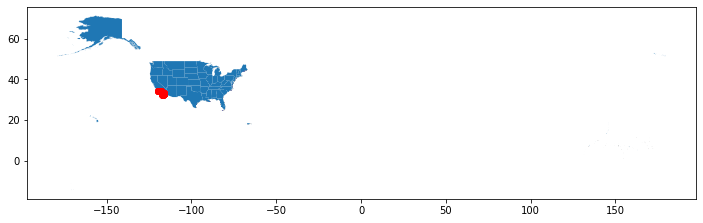

In [8]:
# Confirm only see points in CA approximately
fig, ax = plt.subplots(figsize=(12, 12))
states_gdf.plot(ax=ax)
hpwren_cameras_metadata_gdf.plot(ax=ax, color="red")

<AxesSubplot:>

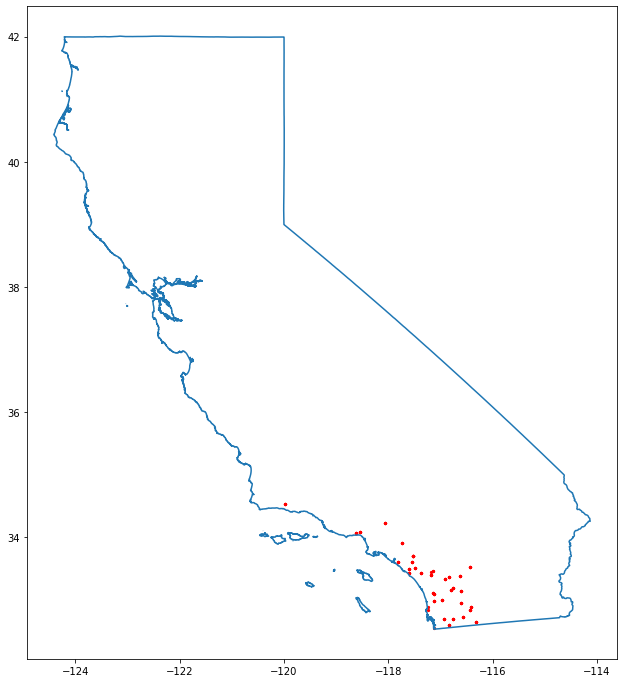

In [9]:
# Confirm only see points in southern CA approximately
fig, ax = plt.subplots(figsize=(12, 12))
states_gdf[states_gdf["STATE"] == "CA"].boundary.plot(ax=ax)
hpwren_cameras_metadata_gdf.plot(
    ax=ax, color="red", markersize=5
)  # keep in mind approx 4 cameras will share same location

### Create master dataset of each camera to each station with distance, is in direction, and row number by closeness

Currently assumes the following:
- lense field of view: 180 degrees
- unknown camera tilt angel, therefore, assume cameras can see 35 miles out (adjustable)

#### Read station metadata and convert to geodataframe

In [10]:
stations_df = pd.read_csv("../../data/raw/station_metadata.csv")
stations_df.shape

(1777, 75)

#### Filter out stations without enough overlap to period of interest

Has to be at least 1 year in from an edge of the timeframe.

In [11]:
# convert columns to datetime
stations_df["PERIOD_OF_RECORD.start"] = pd.to_datetime(
    stations_df["PERIOD_OF_RECORD.start"]
)
stations_df["PERIOD_OF_RECORD.end"] = pd.to_datetime(
    stations_df["PERIOD_OF_RECORD.end"]
)
stations_df[["PERIOD_OF_RECORD.start", "PERIOD_OF_RECORD.end"]].dtypes

PERIOD_OF_RECORD.start    datetime64[ns, UTC]
PERIOD_OF_RECORD.end      datetime64[ns, UTC]
dtype: object

In [12]:
# START_DATETIME = "201606030000"
# END_DATETIME = "202107120000"

# AT LEAST 1 YEAR OF DATA NEEDED FROM ENDS OF TIMEFRAME
end_datetime_dt = datetime.strptime(END_DATETIME, "%Y%m%d%H%M")
buffer_end_datetime_dt = end_datetime_dt - relativedelta(years=1)
start_datetime_dt = datetime.strptime(START_DATETIME, "%Y%m%d%H%M")
buffer_start_datetime_dt = start_datetime_dt + relativedelta(years=1)

stations_df = stations_df[
    (stations_df["PERIOD_OF_RECORD.start"].dt.date <= buffer_end_datetime_dt.date())
    & (stations_df["PERIOD_OF_RECORD.end"].dt.date >= buffer_start_datetime_dt.date())
].copy()
stations_df.shape

(1059, 75)

#### Convert stations to geopandas dataframe

In [13]:
station_geometry = [
    Point(xy) for xy in zip(stations_df.LONGITUDE, stations_df.LATITUDE)
]

# Convert df to geopandas df and append geometry column
stations_gdf = GeoDataFrame(
    stations_df, crs="EPSG:4326", geometry=station_geometry
)  # epsg code 4326 = wgs84
stations_stid_gdf = stations_gdf[["STID", "SHORTNAME", "geometry"]]
stations_stid_gdf

,STID,SHORTNAME,geometry
0,HP001,HPWREN,POINT (-116.42090 32.89220)
1,HP002,HPWREN,POINT (-116.76460 32.70150)
2,HP006,HPWREN,POINT (-116.98340 33.35040)
3,HP009,HPWREN,POINT (-116.61000 33.13000)
4,HP004,HPWREN,POINT (-116.76100 33.18800)
...,...,...,...
1055,SE881,SC-EDISON,POINT (-118.43331 34.41288)
1056,SE882,SC-EDISON,POINT (-118.06385 34.21727)
1057,SE883,SC-EDISON,POINT (-118.20136 34.18815)
1059,HP026,HPWREN,POINT (-118.54880 34.08640)


In [14]:
num_cameras = hpwren_cameras_metadata_gdf.shape[0]
num_stations = stations_stid_gdf.shape[0]
print(f"Num cameras: {num_cameras}")
print(f"Num stations: {num_stations}")
print(f"Num cross product: {num_cameras*num_stations}")

Num cameras: 138
Num stations: 1059
Num cross product: 146142


#### Create cartesian product of cameras x stations

In [15]:
# Create cartesian product of all camera x stations
cross_join_df = hpwren_cameras_metadata_gdf.merge(stations_stid_gdf, how="cross")
cross_join_df = cross_join_df.rename(
    columns={
        "geometry_x": "geometry",
        "STID": "stid",
        "SHORTNAME": "shortname",
        "geometry_y": "geometry_station",
    }
)
# df to gdf
cross_join_gdf = GeoDataFrame(
    cross_join_df, crs="EPSG:4326", geometry=cross_join_df["geometry"]
)

In [16]:
cross_join_gdf

,camera_id,direction,camera_name,image_id,prev_image_ids,long,lat,elevation,geometry.type,geometry.coordinates,x_resolution,y_resolution,center_lat,center_long,properties.description.url,geometry,stid,shortname,geometry_station
0,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",NaN,NaN,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),HP001,HPWREN,POINT (-116.42090 32.89220)
1,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",NaN,NaN,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),HP002,HPWREN,POINT (-116.76460 32.70150)
2,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",NaN,NaN,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),HP006,HPWREN,POINT (-116.98340 33.35040)
3,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",NaN,NaN,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),HP009,HPWREN,POINT (-116.61000 33.13000)
4,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",NaN,NaN,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),HP004,HPWREN,POINT (-116.76100 33.18800)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146137,hpwren_missing10_west,southeast,SMER TCS10 HPWREN,smer-tcs10-mobo-c,['smer-tcs10-mobo-c'],-117.14,33.46,2066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-117.14000 33.46000),SE881,SC-EDISON,POINT (-118.43331 34.41288)
146138,hpwren_missing10_west,southeast,SMER TCS10 HPWREN,smer-tcs10-mobo-c,['smer-tcs10-mobo-c'],-117.14,33.46,2066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-117.14000 33.46000),SE882,SC-EDISON,POINT (-118.06385 34.21727)
146139,hpwren_missing10_west,southeast,SMER TCS10 HPWREN,smer-tcs10-mobo-c,['smer-tcs10-mobo-c'],-117.14,33.46,2066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-117.14000 33.46000),SE883,SC-EDISON,POINT (-118.20136 34.18815)
146140,hpwren_missing10_west,southeast,SMER TCS10 HPWREN,smer-tcs10-mobo-c,['smer-tcs10-mobo-c'],-117.14,33.46,2066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-117.14000 33.46000),HP026,HPWREN,POINT (-118.54880 34.08640)


#### Calc distance between camera and weather station locations

In [17]:
# Calculate distaince between all points
# convert wgs84 to nad83 for meter calculation
cross_join_gdf["geometry_camera_nad83"] = cross_join_gdf["geometry"].to_crs(3310)
cross_join_gdf["geometry_station_nad83"] = cross_join_gdf["geometry_station"].to_crs(
    3310
)


def calc_distance(row):
    distance_m = row["geometry_camera_nad83"].distance(row["geometry_station_nad83"])
    return distance_m


# distance in meters
cross_join_gdf["distance_m"] = cross_join_gdf.apply(
    lambda row: calc_distance(row), axis=1
)
# distance in miles: 1 mile = 1609.344 meters
cross_join_gdf["distance_mi"] = cross_join_gdf["distance_m"] / 1609.344

#### Calculate is in camera direction

In [18]:
# Calculate if station is in camera direction
def is_in_direction(row):
    # assumes a 180 degree field of view (checks if above/below, left/right)
    direction = row["direction"].lower()
    if direction == "north":
        return row["geometry_station"].y >= row["geometry"].y
    elif direction == "east":
        return row["geometry_station"].x >= row["geometry"].x
    elif direction == "south":
        return row["geometry_station"].y <= row["geometry"].y
    elif direction == "west":
        return row["geometry_station"].x <= row["geometry"].x
    else:
        # unknown or something else
        pass


cross_join_gdf["is_in_direction"] = cross_join_gdf.apply(
    lambda row: is_in_direction(row), axis=1
)

#### Filter out if not in direction + some manuasl before calculating the row number in terms of closeness

The filter is done first because some of the closest stations to a camera might not necessarily be in its direction. Therefore, it's possible that the top x might not be in direction, and then when choosing the top x, the number of off and it shows none.

In [19]:
# Calculate row number by closeness
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
cross_join_gdf = cross_join_gdf.sort_values(
    ["camera_id", "distance_mi"], ascending=[True, True]
)

########################################################
## Additional filters #################################
# filter out the not in directions for proper cumcount
cross_join_filter_gdf = cross_join_gdf[
    cross_join_gdf["is_in_direction"] != False
].copy()

# manually filter out known stations with null percentages > 20%
stations_to_filter_out = ["HP003", "HP006", "HP015", "HP025"]
cross_join_filter_gdf = cross_join_filter_gdf[
    ~cross_join_filter_gdf["stid"].isin(stations_to_filter_out)
].copy()
########################################################
########################################################

cross_join_filter_gdf["rn"] = (
    cross_join_filter_gdf.groupby(["camera_id"]).cumcount() + 1
)

#### Quick look at result

In [20]:
cross_join_filter_gdf

,camera_id,direction,camera_name,image_id,prev_image_ids,long,lat,elevation,geometry.type,geometry.coordinates,...,geometry,stid,shortname,geometry_station,geometry_camera_nad83,geometry_station_nad83,distance_m,distance_mi,is_in_direction,rn
170,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),BFDSD,SDGE,POINT (-117.09673 32.54197),POINT (270907.903 -602745.446),POINT (273123.340 -603567.295),2362.963219,1.468277,None,1
156,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),CVXSD,SDGE,POINT (-117.05801 32.60159),POINT (270907.903 -602745.446),POINT (276559.938 -596857.216),8161.908209,5.071575,None,2
661,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),DJZSD,SDGE,POINT (-117.11030 32.64190),POINT (270907.903 -602745.446),POINT (271509.966 -592547.121),10216.081526,6.347979,None,3
166,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),NATSD,SDGE,POINT (-117.09669 32.65434),POINT (270907.903 -602745.446),POINT (272746.158 -591131.221),11758.801848,7.306581,None,4
18,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.12,32.55,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),MIGSD,SDGE,POINT (-116.98091 32.68478),POINT (270907.903 -602745.446),POINT (283511.973 -587422.493),19840.752587,12.328472,None,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144595,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.15,33.46,2063.0,NaN,NaN,...,POINT (-117.15000 33.46000),SE406,SC-EDISON,POINT (-119.26899 38.22056),POINT (265056.727 -502062.185),POINT (63918.430 22945.879),562218.891429,349.346623,True,737
144592,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.15,33.46,2063.0,NaN,NaN,...,POINT (-117.15000 33.46000),SE403,SC-EDISON,POINT (-119.22612 38.25832),POINT (265056.727 -502062.185),POINT (67632.575 27173.066),564859.492666,350.987416,True,738
144594,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.15,33.46,2063.0,NaN,NaN,...,POINT (-117.15000 33.46000),SE405,SC-EDISON,POINT (-119.21323 38.30325),POINT (265056.727 -502062.185),POINT (68717.613 32176.768),569175.111170,353.669017,True,739
144591,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.15,33.46,2063.0,NaN,NaN,...,POINT (-117.15000 33.46000),SE402,SC-EDISON,POINT (-119.34465 38.35050),POINT (265056.727 -502062.185),POINT (57203.097 37341.815),578065.573600,359.193295,True,740


#### Apply filter logic to master dataset to find matches within criterium

In [21]:
# is_in_direction is still included as safety net, but already filtered out at this point

cross_join_matches_gdf = cross_join_filter_gdf[
    (cross_join_filter_gdf["distance_mi"] <= MILES)
    & (cross_join_filter_gdf["is_in_direction"] != False)
    & (cross_join_filter_gdf["rn"] <= CLOSEST_X)
].copy()
cross_join_matches_gdf

,camera_id,direction,camera_name,image_id,prev_image_ids,long,lat,elevation,geometry.type,geometry.coordinates,...,geometry,stid,shortname,geometry_station,geometry_camera_nad83,geometry_station_nad83,distance_m,distance_mi,is_in_direction,rn
170,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),BFDSD,SDGE,POINT (-117.09673 32.54197),POINT (270907.903 -602745.446),POINT (273123.340 -603567.295),2362.963219,1.468277,None,1
156,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),CVXSD,SDGE,POINT (-117.05801 32.60159),POINT (270907.903 -602745.446),POINT (276559.938 -596857.216),8161.908209,5.071575,None,2
661,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",...,POINT (-117.12000 32.55000),DJZSD,SDGE,POINT (-117.11030 32.64190),POINT (270907.903 -602745.446),POINT (271509.966 -592547.121),10216.081526,6.347979,None,3
36118,hpwren11_east,east,Los Pinos,pi-e-mobo-c,['pi-e-mobo'],-116.577658,32.734516,4800.0,Point,"[-116.58, 32.73, 4800]",...,POINT (-116.57766 32.73452),CTMSD,SDGE,POINT (-116.54971 32.78287),POINT (321165.632 -580631.983),POINT (323592.432 -575185.363),5962.804027,3.705115,True,1
36037,hpwren11_east,east,Los Pinos,pi-e-mobo-c,['pi-e-mobo'],-116.577658,32.734516,4800.0,Point,"[-116.58, 32.73, 4800]",...,POINT (-116.57766 32.73452),MORSD,SDGE,POINT (-116.51244 32.68833),POINT (321165.632 -580631.983),POINT (327471.351 -585520.106),7978.460674,4.957586,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143028,hpwren_missing8_west,east,SMER TCS3 HPWREN,smer-tcs3-mobo-c,['smer-tcs3-mobo-c'],-117.180000,33.450000,1400.0,NaN,NaN,...,POINT (-117.18000 33.45000),RNBSD,SDGE,POINT (-117.14413 33.41892),POINT (262300.450 -503253.635),POINT (265739.633 -506597.364),4796.717385,2.980542,True,2
143030,hpwren_missing8_west,east,SMER TCS3 HPWREN,smer-tcs3-mobo-c,['smer-tcs3-mobo-c'],-117.180000,33.450000,1400.0,NaN,NaN,...,POINT (-117.18000 33.45000),RBVSD,SDGE,POINT (-117.17017 33.40122),POINT (262300.450 -503253.635),POINT (263376.152 -508630.978),5483.881023,3.407526,True,3
144272,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.150000,33.460000,2063.0,NaN,NaN,...,POINT (-117.15000 33.46000),SE073,SC-EDISON,POINT (-117.17798 33.41945),POINT (265056.727 -502062.185),POINT (262589.067 -506632.958),5194.353048,3.227621,True,1
144277,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.150000,33.460000,2063.0,NaN,NaN,...,POINT (-117.15000 33.46000),SE078,SC-EDISON,POINT (-117.18817 33.49929),POINT (265056.727 -502062.185),POINT (261378.719 -497814.627),5618.673314,3.491282,True,2


### Join back to original camera dataset to account for none matches

In [22]:
hpwren_cameras_metadata_gdf.shape

(138, 16)

In [23]:
cams_to_stations_df = hpwren_cameras_metadata_gdf.merge(
    cross_join_matches_gdf[
        [
            "camera_id",
            "stid",
            "shortname",
            "distance_m",
            "distance_mi",
            "is_in_direction",
            "rn",
        ]
    ],
    on="camera_id",
    how="left",
)
cams_to_stations_df

,camera_id,direction,camera_name,image_id,prev_image_ids,long,lat,elevation,geometry.type,geometry.coordinates,...,center_lat,center_long,properties.description.url,geometry,stid,shortname,distance_m,distance_mi,is_in_direction,rn
0,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",...,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),BFDSD,SDGE,2362.963219,1.468277,None,1
1,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",...,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),CVXSD,SDGE,8161.908209,5.071575,None,2
2,hpwren0_unknown direction,unknown direction,NaN,tje-1-mobo-c,[''],-117.120000,32.550000,10.0,Point,"[-117.12, 32.55, 10]",...,NaN,NaN,http://hpwren.ucsd.edu/cameras/TJE.html,POINT (-117.12000 32.55000),DJZSD,SDGE,10216.081526,6.347979,None,3
3,hpwren1_north,north,Big Black Mountain,bm-n-mobo-c,[''],-116.808092,33.159927,4055.0,Point,"[-116.8081, 33.1599, 4055]",...,33.181599,-116.807554,http://hpwren.ucsd.edu/cameras/BBlackMtn.html,POINT (-116.80809 33.15993),MGDSD,SDGE,4635.802946,2.880554,True,1
4,hpwren1_north,north,Big Black Mountain,bm-n-mobo-c,[''],-116.808092,33.159927,4055.0,Point,"[-116.8081, 33.1599, 4055]",...,33.181599,-116.807554,http://hpwren.ucsd.edu/cameras/BBlackMtn.html,POINT (-116.80809 33.15993),HP004,HPWREN,5385.340294,3.346295,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.150000,33.460000,2063.0,NaN,NaN,...,NaN,NaN,NaN,POINT (-117.15000 33.46000),SE078,SC-EDISON,5618.673314,3.491282,True,2
408,hpwren_missing9_west,west,SMER TCS8 HPWREN,smer-tcs8-mobo-c,['smer-tcs8-mobo-c'],-117.150000,33.460000,2063.0,NaN,NaN,...,NaN,NaN,NaN,POINT (-117.15000 33.46000),SE772,SC-EDISON,6565.788330,4.079792,True,3
409,hpwren_missing10_west,southeast,SMER TCS10 HPWREN,smer-tcs10-mobo-c,['smer-tcs10-mobo-c'],-117.140000,33.460000,2066.0,NaN,NaN,...,NaN,NaN,NaN,POINT (-117.14000 33.46000),RNBSD,SDGE,4569.855429,2.839577,None,1
410,hpwren_missing10_west,southeast,SMER TCS10 HPWREN,smer-tcs10-mobo-c,['smer-tcs10-mobo-c'],-117.140000,33.460000,2066.0,NaN,NaN,...,NaN,NaN,NaN,POINT (-117.14000 33.46000),SE073,SC-EDISON,5717.613228,3.552760,None,2


#### Null weather station mappings

In [24]:
cams_to_stations_df[cams_to_stations_df["stid"].isna()]

,camera_id,direction,camera_name,image_id,prev_image_ids,long,lat,elevation,geometry.type,geometry.coordinates,...,center_lat,center_long,properties.description.url,geometry,stid,shortname,distance_m,distance_mi,is_in_direction,rn


### Write camera to weather station mapping file to CSV in processed folder

In [25]:
cams_to_stations_df[
    [
        "camera_id",
        "image_id",
        "stid",
        "shortname",
        "distance_m",
        "distance_mi",
        "is_in_direction",
        "rn",
    ]
].to_csv("../../data/processed/camera_station_mappings.csv", index=False)

### Denormalize for easier mapping view if needed

In [26]:
cams_to_stations_map_df = pd.DataFrame(
    cams_to_stations_df[["camera_id", "stid"]]
    .groupby(["camera_id"])["stid"]
    .apply(list)
)
cams_to_stations_map_df

,stid
camera_id,
hpwren0_unknown direction,"[BFDSD, CVXSD, DJZSD]"
hpwren11_east,"[CTMSD, MORSD, BMSSD]"
hpwren11_north,"[CTMSD, BMSSD, JVRSD]"
hpwren11_south,"[MORSD, RPOSD, NPTSD]"
hpwren11_west,"[JVRSD, RPOSD, NPTSD]"
...,...
hpwren_missing7_north,"[HP018, SE453, SE830]"
hpwren_missing7_south,"[SE098, SE080, SE135]"
hpwren_missing7_west,"[HP018, SE098, SE080]"
